In [2]:
from tqdm import tqdm
import numpy as np
%matplotlib inline

import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as tr

from data import BraTSDatasetUnet, BraTSDatasetLSTM
from losses import DICELossMultiClass
from models import UNet


In [4]:
DATA_FOLDER = 'Data/'

dset_train = BraTSDatasetUnet(DATA_FOLDER, train=True, keywords=['flair'], im_size=[1024, 1024], transform=tr.ToTensor())

train_loader = DataLoader(dset_train, batch_size=4, shuffle=True, num_workers=1)

dset_test = BraTSDatasetUnet(DATA_FOLDER, train=False, keywords=['flair'], im_size=[1024, 1024], transform=tr.ToTensor())

test_loader = DataLoader(dset_test, batch_size=4, shuffle=False, num_workers=1)

print("Training Data : ", len(train_loader.dataset))
print("Test Data :", len(test_loader.dataset))

Training Data :  305
Test Data : 16


torch.Size([4, 3, 1024, 1024]) torch.Size([4, 3, 1024, 1024])


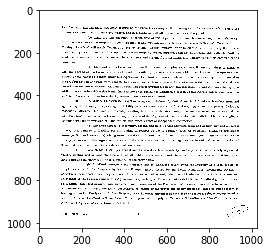

In [4]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = (inp * 255).astype(np.uint8)
    return inp


inputs, masks = next(iter(test_loader))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[3]))

In [5]:
from PIL import Image
img = Image.fromarray(reverse_transform(inputs[3]), 'RGB')
img.save('my.png')

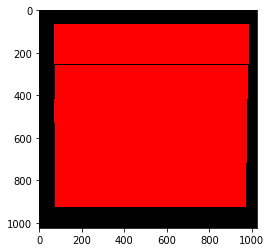

In [6]:
plt.imshow(reverse_transform(masks[3]))

In [7]:
from PIL import Image

img = Image.open(r'D:\Demos\unet-demo\WorkSpace\UNet\Data\Test\masked\1538681125628_4739745.Lease Agreements. _001.png').convert('L')
img.save('greyscale.png')
resized_img = img.resize((1024, 1024))
transform=tr.ToTensor()
trans_img = transform(resized_img)
trans_img.shape

torch.Size([1, 1024, 1024])

In [9]:
trans=tr.ToPILImage()
trans(trans_img).save('back.png')


In [46]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import shutil

In [58]:
def dilate_text(input_file_path, output_file_path, xmin, ymin, xmax, ymax):
    input = cv2.imread(input_file_path)
    height, width, _ = input.shape
    masked_image = np.zeros((height, width, 1), dtype=np.uint8)
    color = 255
    cv2.rectangle(masked_image, (xmin, ymin), (xmax, ymax), color, -1)
    
    image = cv2.imread(input_file_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    roi = thresh[ymin:ymax, xmin:xmax]
    roi[:] = cv2.dilate(roi, kernel, iterations=5)
    
    masked_image = cv2.bitwise_and(thresh, masked_image)
    cv2.imwrite(output_file_path, masked_image)

In [59]:
dilate_text(r'D:\Demos\unet-demo\WorkSpace\UNet Binary\Data\images\1538681144691_682774.Option_Lease_Agreements._.TIF-7.png',
                     r'D:\Demos\unet-demo\WorkSpace\UNet Binary\Data\z.png', 52,49,379,483)

In [ ]:
#images/1538681144691_682774.Option_Lease_Agreements._.TIF-7.png,408,552,BT_Text,52,49,379,483
#images/1538681144691_682774.Option_Lease_Agreements._.TIF-7.png,408,552,BT_Text,212,495,219,504

In [71]:
def process_records_dilated(input_path):
    records = pd.read_csv(os.path.join(input_path, 'train.csv'))
    classes = records['class'].unique().tolist()
    print(classes)
    
    masked_directory = os.path.join(input_path, 'dilated')
    if os.path.exists(masked_directory):
        shutil.rmtree(masked_directory)
    os.makedirs(masked_directory)

    grouped = records.groupby('filename')
    for key, df_group in grouped:
        image_path = os.path.join(input_path, key.strip())
        if not os.path.isfile(image_path):
            continue
        filename = os.path.basename(image_path)
        masked_img_path = os.path.join(masked_directory, filename)
        
        roi_list = []
        for row_index, row in df_group.iterrows():
            class_name = row["class"].strip()
            if class_name == 'BT_Text':
                xmin = math.floor(float(row["xmin"]))
                ymin = math.floor(float(row["ymin"]))
                xmax = math.ceil(float(row["xmax"]))
                ymax = math.ceil(float(row["ymax"]))
                roi_list.append((xmin, ymin, xmax, ymax))

        input_image = cv2.imread(image_path)
        height, width, _ = input_image.shape
        temp = np.zeros((height, width, 1), dtype=np.uint8)

        gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        
        for (xmin, ymin, xmax, ymax) in roi_list:
            cv2.rectangle(temp, (xmin, ymin), (xmax, ymax), 255, -1)

            roi = thresh[ymin:ymax, xmin:xmax]
            roi[:] = cv2.dilate(roi, kernel, iterations=5)
        
        masked_image = cv2.bitwise_and(thresh, temp)
        cv2.imwrite(masked_img_path, masked_image)     

In [72]:
input_path = r'D:\Demos\unet-demo\WorkSpace\UNet Binary\Data'
process_records_dilated(input_path)

['BT_Text', 'BT_RasterPicture', 'BT_Table', 'BT_VectorPicture']


In [52]:
def process_records_binary(input_path):
    records = pd.read_csv(os.path.join(input_path, 'train.csv'))
    classes = records['class'].unique().tolist()
    print(classes)
    
    masked_directory = os.path.join(input_path, 'masked')
    
    if os.path.exists(masked_directory):
        shutil.rmtree(masked_directory)
    os.makedirs(masked_directory)
    
    for index, row in records.iterrows():
        image_path = row["filename"].strip()
        image_path = os.path.join(input_path, image_path)
        if not os.path.isfile(image_path):
            continue
        filename = os.path.basename(image_path)
        masked_img_path = os.path.join(masked_directory, filename)
        
        if os.path.isfile(masked_img_path):
            image = cv2.imread(masked_img_path, 0)
        else:
            input = cv2.imread(image_path)
            height, width, _ = input.shape
            image = np.zeros((height, width, 1), dtype=np.uint8)
            #image = np.full((height, width, 3), 255, dtype=np.uint8)
        
        class_name = row["class"].strip()
        if class_name == 'BT_Text':
            print('Processing record at index:', index)
            color = 255
            xmin = math.floor(float(row["xmin"]))
            ymin = math.floor(float(row["ymin"]))
            xmax = math.ceil(float(row["xmax"]))
            ymax = math.ceil(float(row["ymax"]))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, -1)
        cv2.imwrite(masked_img_path, image)

In [53]:
input_path = r'D:\Demos\unet-demo\WorkSpace\UNet Binary\Data'
process_records_binary(input_path)

['BT_Text', 'BT_RasterPicture', 'BT_Table', 'BT_VectorPicture']
Processing record at index: 324
Processing record at index: 325
Processing record at index: 326
Processing record at index: 475
Processing record at index: 476
Processing record at index: 478
Processing record at index: 479
Processing record at index: 480
Processing record at index: 1674
Processing record at index: 1675
Processing record at index: 1676
Processing record at index: 1677
Processing record at index: 1680
Processing record at index: 1682
Processing record at index: 1810
Processing record at index: 1811
Processing record at index: 3161
Processing record at index: 3162
Processing record at index: 6156
Processing record at index: 6162
Processing record at index: 6209
Processing record at index: 6776
Processing record at index: 6777
Processing record at index: 6990
Processing record at index: 6991
Processing record at index: 6992
Processing record at index: 6993
Processing record at index: 6995
Processing record at